# 이미지의 해상도를 향상시켜보자!

# Project 1-1
  - 이미지 불러오기
  - resize, 보간법 적용
  - 시각화
  - Model : SRCNN
  - Model : SRGAN
  - OOM 오류 해결
  - 학습 된 가중치 불러오기
  - 추론 및 시각화
# Project 1-2
  - 낮은 해상도 높이기
# Project 2
  - GIF 만들기

In [73]:
import cv2
import os
import matplotlib.pyplot as plt

import tensorflow as tf
import os
import numpy as np

import cv2


import numpy as np

import tensorflow as tf
import os


# Project 1-1

# 이미지 불러오기

(1200, 1800, 3)


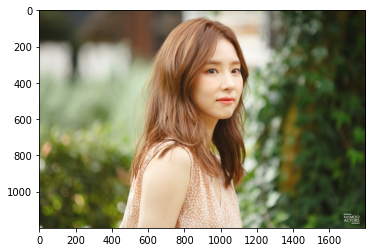

In [74]:
image_path = os.getenv('HOME') + '/aiffel/Exploration/girl.jpg'
hr_image = cv2.imread(image_path)
hr_image = cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB)
print(hr_image.shape)
plt.imshow(hr_image)

### 이미지 Resize

(300, 450, 3)


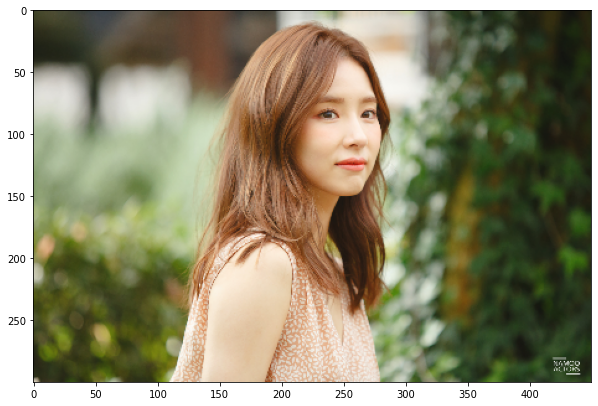

In [75]:
lr_image = cv2.resize(hr_image, dsize=(450,300)) # (가로 픽셀 수, 세로 픽셀 수)
print(lr_image.shape)

plt.figure(figsize=(10,10))
plt.imshow(lr_image)

### 보간법 적용

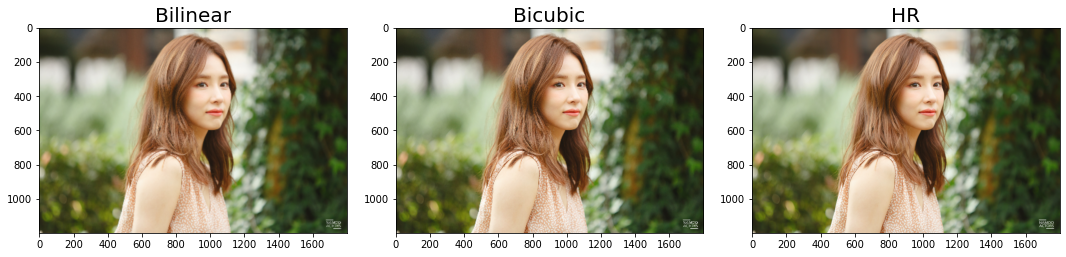

In [76]:
bilinear_image = cv2.resize(
    lr_image, 
    dsize=(1800, 1200), # (가로 픽셀 수, 세로 픽셀 수) 
    interpolation=cv2.INTER_LINEAR # bilinear interpolation 적용
)

bicubic_image = cv2.resize(
    lr_image, 
    dsize=(1800, 1200), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

images = [bilinear_image, bicubic_image, hr_image]
titles = ["Bilinear", "Bicubic", "HR"]

plt.figure(figsize=(15,10))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)
    
plt.tight_layout()

### 적용결과 자세히보기

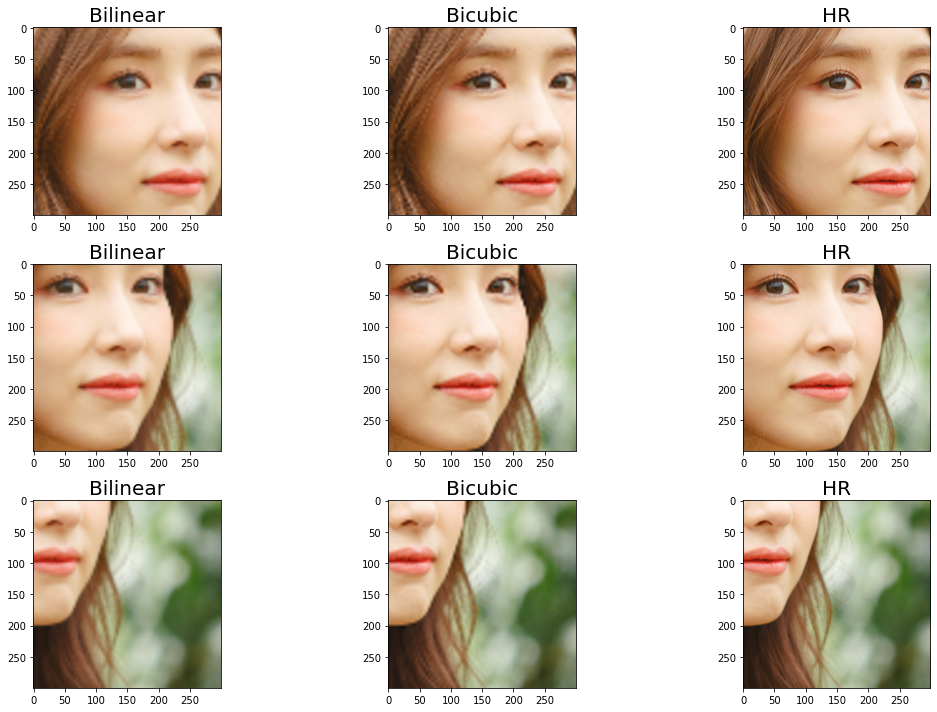

In [77]:
# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=300, y=300):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]


# 잘라낼 영역의 좌표를 정의합니다.
left_tops = [(250,800)] *3 + [(300,900)] *3 + [(400,1000)] *3

plt.figure(figsize=(16,10))
for i, (image, left_top, title) in enumerate(zip(images*3, left_tops, titles*3)):
    plt.subplot(3,3,i+1)
    plt.imshow(crop(image, left_top))
    plt.title(title, fontsize=20)
    
plt.tight_layout()

# Model : SRCNN

In [78]:
from tensorflow.keras import layers, Sequential

# 3개의 convolutional layer를 갖는 Sequential 모델을 구성합니다.
srcnn = Sequential()
# 9x9 크기의 필터를 128개 사용합니다.
srcnn.add(layers.Conv2D(128, 9, padding="same", input_shape=(None, None, 3)))
srcnn.add(layers.ReLU())
# 5x5 크기의 필터를 64개 사용합니다.
srcnn.add(layers.Conv2D(64, 5, padding="same"))
srcnn.add(layers.ReLU())
# 5x5 크기의 필터를 64개 사용합니다.
srcnn.add(layers.Conv2D(3, 5, padding="same"))

srcnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, None, None, 128)   31232     
_________________________________________________________________
re_lu_2 (ReLU)               (None, None, None, 128)   0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 64)    204864    
_________________________________________________________________
re_lu_3 (ReLU)               (None, None, None, 64)    0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 3)     4803      
Total params: 240,899
Trainable params: 240,899
Non-trainable params: 0
_________________________________________________________________


### 학습된 가중치 불러오기

In [79]:
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srcnn.h5'
srcnn = tf.keras.models.load_model(model_file)

def apply_srcnn(image):
    sr = srcnn.predict(image[np.newaxis, ...]/255.)
    sr[sr > 1] = 1
    sr[sr < 0] = 0
    sr *= 255.
    return np.array(sr[0].astype(np.uint8))

srcnn_hr = apply_srcnn(bicubic_image)

# 추론

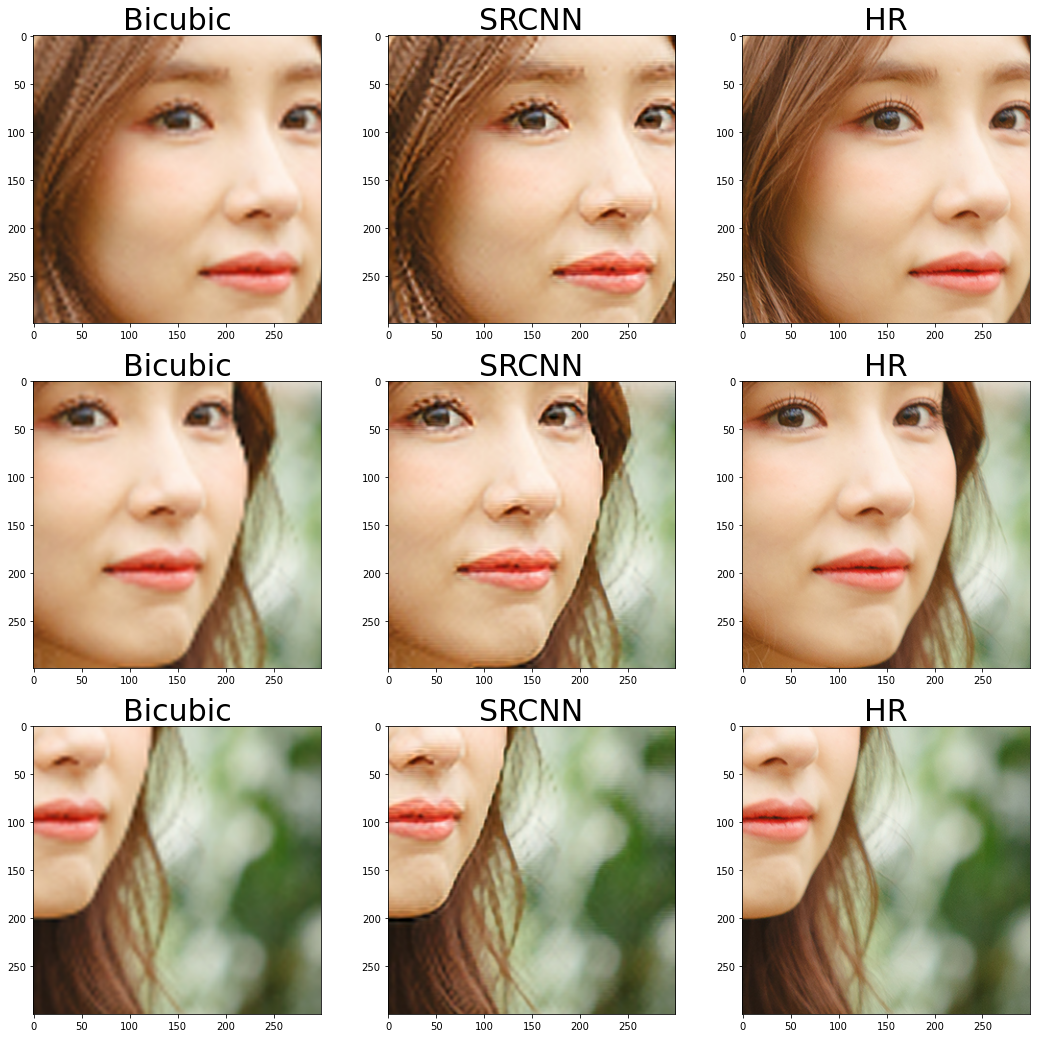

In [80]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(250,800),(300,900),(400,1000)]
                                  
images = []
for left_top in left_tops:
    img1 = crop(bicubic_image, left_top, 300, 300)
    img2 = crop(srcnn_hr , left_top, 300, 300)
    img3 = crop(hr_image, left_top, 300, 300)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRCNN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

# Model : SRGAN

### Generator

In [81]:
from tensorflow.keras import Input, Model, layers

# 그림의 파란색 블록을 정의합니다.
def gene_base_block(x):
    out = layers.Conv2D(64, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.PReLU(shared_axes=[1,2])(out)
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.Add()([x, out])

# 그림의 뒤쪽 연두색 블록을 정의합니다.
def upsample_block(x):
    out = layers.Conv2D(256, 3, 1, "same")(x)
    # 그림의 PixelShuffler 라고 쓰여진 부분을 아래와 같이 구현합니다.
    out = layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))(out)
    return layers.PReLU(shared_axes=[1,2])(out)
    
# 전체 Generator를 정의합니다.
def get_generator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 9, 1, "same")(inputs)
    out = residual = layers.PReLU(shared_axes=[1,2])(out)
    
    for _ in range(5):
        out = gene_base_block(out)
    
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.Add()([residual, out])
    
    for _ in range(2):
        out = upsample_block(out)
        
    out = layers.Conv2D(3, 9, 1, "same", activation="tanh")(out)
    return Model(inputs, out)

print("✅")

✅


### Discriminator

In [82]:
# 그림의 파란색 블록을 정의합니다.
def disc_base_block(x, n_filters=128):
    out = layers.Conv2D(n_filters, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(n_filters, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.LeakyReLU()(out)

# 전체 Discriminator 정의합니다.
def get_discriminator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 3, 1, "same")(inputs)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(64, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    
    for n_filters in [128, 256, 512]:
        out = disc_base_block(out, n_filters)
    
    out = layers.Dense(1024)(out)
    out = layers.LeakyReLU()(out)
    out = layers.Dense(1, activation="sigmoid")(out)
    return Model(inputs, out)

print("✅")

✅


### Feature Extractor

In [83]:
from tensorflow.python.keras import applications
def get_feature_extractor(input_shape=(None, None, 3)):
    vgg = applications.vgg19.VGG19(
        include_top=False, 
        weights="imagenet", 
        input_shape=input_shape
    )
    # 아래 vgg.layers[20]은 vgg 내의 마지막 convolutional layer 입니다.
    return Model(vgg.input, vgg.layers[20].output)

print("✅")

✅


### 사전 학습된 가중치 불러오기

In [89]:
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

### OOM 오류 해결
사이즈 변경

In [101]:
bicubic_re = cv2.resize(bicubic_image, dsize=(900, 600))
srgan_hr = apply_srgan(bicubic_re)

srgan_hr = cv2.resize(srgan_hr, dsize=(900, 600))
bicubic_image = cv2.resize(bicubic_image, dsize=(900, 600))
hr_image = cv2.resize(hr_image, dsize=(900, 600))

# 추론

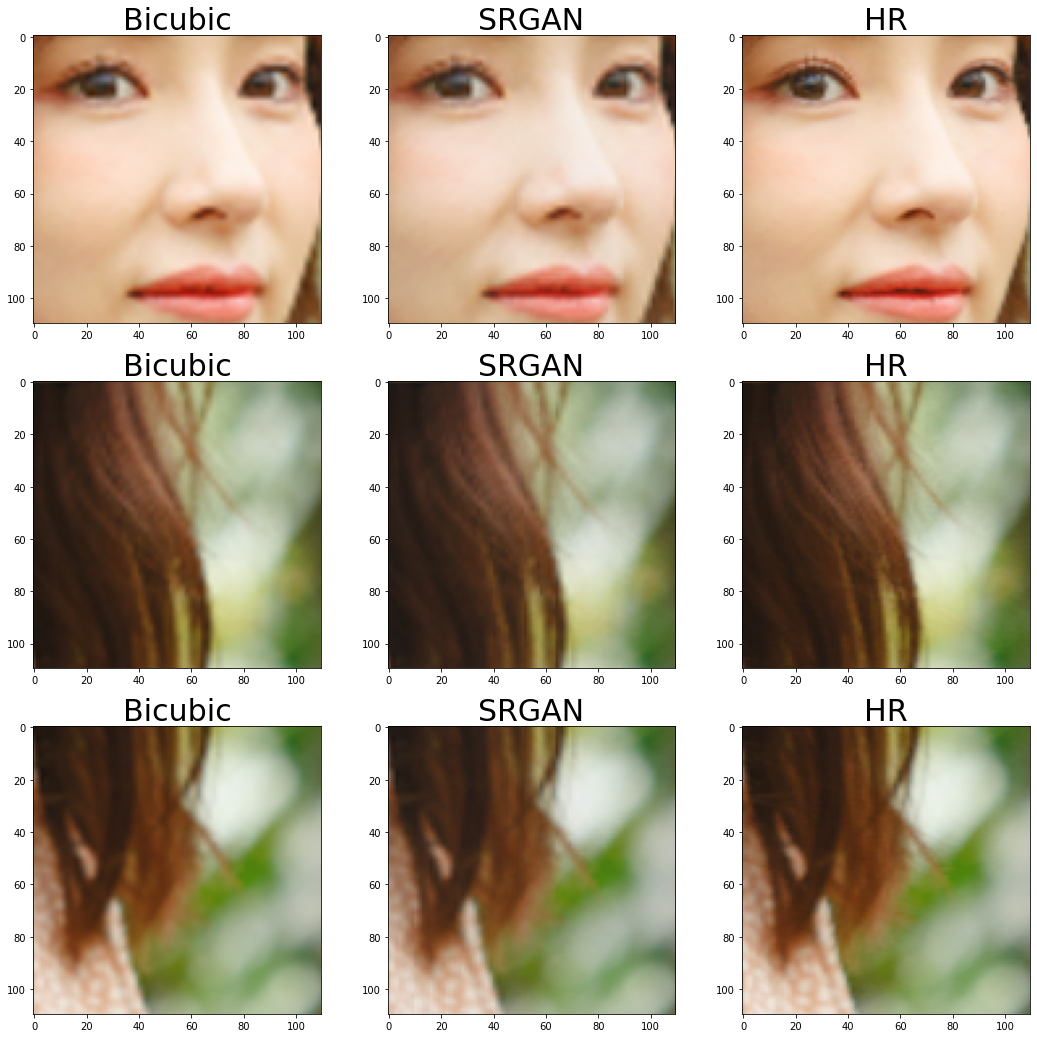

In [108]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(150,450),(300,500),(400,500)]

images = []   
for left_top in left_tops:
    img1 = crop(bicubic_image, left_top, 110, 110)
    img2 = crop(srgan_hr , left_top, 110, 110)
    img3 = crop(hr_image, left_top, 110, 110)
    images.extend([img1, img2, img3])
    
labels = ["Bicubic", "SRGAN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

# Project 1-2

# 이미지 불러오기
해상도가 낮은 이미지

(96, 96, 3)


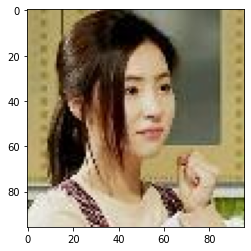

In [17]:
import cv2
import os
import matplotlib.pyplot as plt

image_path = os.getenv('HOME') + '/aiffel/Exploration/girl2.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_re = cv2.resize(image, dsize=(384, 384))
print(image.shape)
plt.imshow(image)

### SRGAN 적용

In [18]:
srgan_hr = apply_srgan(image)
print(srgan_hr.shape)

(384, 384, 3)


### 시각화

Text(0.5, 1.0, 'SRGAN')

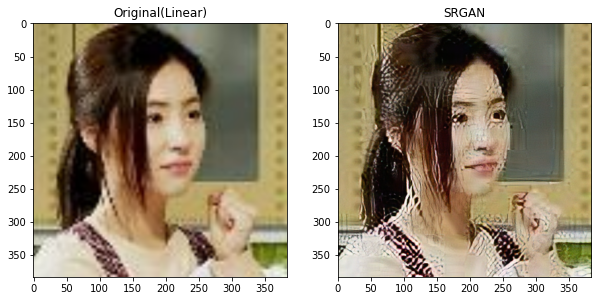

In [19]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(image_re); plt.title('Original(Linear)')
plt.subplot(1,2,2)
plt.imshow(srgan_hr); plt.title('SRGAN')

# Project 2

### GIF 파일 불러오기

In [20]:
import cv2

# 다운받은 파일의 경로를 설정해 주세요.
gif = cv2.VideoCapture("example.gif")

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 8
frame 크기 : (255, 500, 3)


### Frame별 SRGAN 적용

In [21]:
frames_sr = []
for f in frames:
    re = apply_srgan(f)
    frames_sr.append(re)
    
print(len(frames_sr))

8


### 다시 GIF 파일로 변환

In [22]:
import imageio

imageio.mimsave("result.gif", frames_sr)

# GIF 시각화

In [1]:
from IPython.display import Image as show_gif

### 저해상도

![ㅁㄴㅇㄹ](example.gif)

### 고해상도

<img src="result.gif" width=500/>

# 결과 및 고찰
- 실험 결과 모델보다 보간법이 더 깔끔한 결과가 나온 것 같다.
- 그리고 생각했던 것 보다 성능이 좋지 않은 것 같다.
- 사이즈가 큰 이미지에 대해서는 어느정도 적용이 되는 것 같다.
- 하지만 처음부터 해상도가 낮았던 이미지의 해상도를 좋게 하는 건 어려운 것 같다.
> **새로운 경험을 한 것 같다.**